# Experiments for Classification using Titanic Dataset

In [1]:
#Loading data 
import pandas as pd
titanic = pd.read_csv("titanic_dataset.csv")
titanic = titanic.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'])
titanic.describe()

,Unnamed: 0,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,0.647587,2.167228,0.381594,1.505051,0.361392,0.228956,1.904602,0.602694,2.053872
std,257.353842,0.486592,0.836071,0.477990,7.614599,0.806057,1.118148,0.635673,0.420397,1.613459,0.489615,1.335519
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,222.500000,0.000000,2.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,445.000000,0.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,667.500000,1.000000,3.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,2.000000,1.000000,3.000000
max,890.000000,1.000000,3.000000,1.000000,80.000000,6.000000,3.000000,2.000000,1.000000,11.000000,1.000000,5.000000


In [2]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)
    
def rademacher_bound(array_x, delta, train_error, array_Rademacher):
    c =3*(np.sqrt(np.log(2/delta))/((array_x)))
    bound = np.add(train_error, array_Rademacher)
    bound = np.add(bound,c)
    return(bound)

def vc_dimension_classification(array_x, array_Rademacher):
    c = array_x/(2*np.log(array_x))
    VC = (array_Rademacher**2)*c
    return(VC)

def VC_bound(array_x, train_error, array_VCdim, delta):
    a = np.log(array_x/array_VCdim)
    a = np.where(a > 0, a, 0)
    c = np.log(delta/4)
    eta = ((array_VCdim*(a +1)) - c)/array_x
    eta[np.isnan(eta)] = 0
    VCbound = train_error + ((eta/2)*(1 + np.sqrt(1+((4*train_error)/eta))))
    VCbound[np.isnan(VCbound)] = 0
    return(VCbound)

## Experiment 1:  Evaluating how train and test error varies with increasing training set size.

<br>Empirical train and test error: Missclassification rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Test Samples = 50
<br>Train Samples = [10,20,30,40,....,150]
<br>We run each sample size 100 times and take the average for calculating the empirical erros to reduce noise. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from random import sample

n = range(10,160,10)
n_2 = range(0,100)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []

#Test set
df_x = titanic
df_x = df_x.drop(columns = ['Survived'])
df_y = titanic['Survived']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.056)


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - data generation
        idx = sample(range(0,len(X)), value)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        # Create Decision Tree classifer object
        clf = DecisionTreeClassifier(max_depth= 2)

        #inserting train data in model for training
        clf.fit(X_train,Y_train)

        #predicting values for train/test data
        Y_pred_test = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)

        #computing misclassification error
        acc_test = clf.score(X_test, Y_test)
        temp_test.append(1-acc_test)

        acc_train= clf.score(X_train, Y_train)
        temp_train.append(1-acc_train)

        #Rademacher constant`
        scores = np.asarray(Y_train).flatten() != Y_pred_train
        L = np.dot(s, scores)/len(Y_train)
        temp_L.append(L)

    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(np.array(n), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_classification(np.array(n), np.array(Rad))
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(np.array(n), np.array(train_error), VCdim, 0.1)
print("VC Bound")
print(VCBound)

Rademacher Constant
[0.2, 0.2, 0.13333333333333333, 0.15, 0.1, 0.11666666666666667, 0.14285714285714285, 0.0875, 0.1111111111111111, 0.09, 0.08181818181818182, 0.08333333333333333, 0.07692307692307693, 0.08571428571428572, 0.07333333333333333]
Rademacher Bound
[0.76424551 0.55512276 0.4307485  0.41856138 0.3552491  0.36654092
 0.37789222 0.31565569 0.3402495  0.31362455 0.30256777 0.30693713
 0.29632658 0.30230325 0.2875497 ]
VC Dimension
[0.0868589  0.13352328 0.07840376 0.12198826 0.06390555 0.09973106
 0.16812675 0.06988775 0.12346201 0.08794463 0.07832855 0.08703235
 0.07901647 0.10407182 0.08049545]
VC Bound
[0.50478595 0.3923152  0.34497376 0.3325464  0.31317993 0.31603299
 0.30702415 0.28667184 0.29447507 0.28329016 0.27826315 0.28209473
 0.27551109 0.27374726 0.26802057]


Test
[0.31660000000000005, 0.30260000000000004, 0.263, 0.2395999999999999, 0.23639999999999983, 0.23879999999999996, 0.2075999999999999, 0.21059999999999987, 0.1947999999999999, 0.20459999999999995, 0.19359999999999997, 0.1937999999999999, 0.1907999999999999, 0.18919999999999992, 0.18759999999999993]
Train
[0.04500000000000001, 0.09549999999999999, 0.12433333333333316, 0.13875, 0.15139999999999992, 0.16333333333333333, 0.16085714285714256, 0.16325000000000006, 0.1714444444444442, 0.1717, 0.17354545454545456, 0.18033333333333335, 0.17946153846153826, 0.1794999999999999, 0.17960000000000004]


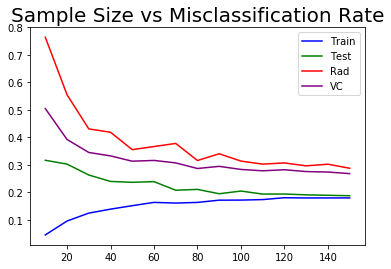

In [4]:
# Step 3: Evaluation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

print('Test')
print(test_error)
print("Train")
print(train_error)

plt.title('Sample Size vs Misclassification Rate',fontsize=20)
plt.plot(n,train_error,color='blue', label = 'Train')
plt.plot(n,test_error,color = 'green', label = 'Test')
plt.plot(n,radBound, color = 'red', label = 'Rad')
plt.plot(n,VCBound, color = 'purple', label = 'VC')
plt.legend(loc='upper right')
plt.show()

[[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150]]


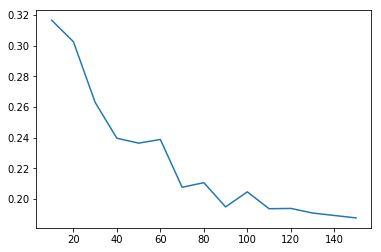

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    18.58      1.45239e+12       15          48.6743          37.2653     15.27s
   1    16.91      3.40977e+08       19          34.1774              9.9     14.80s
   2    17.14       1.7665e+07       30          27.3159             54.5     12.00s
   3    17.72       1.3126e+08       35          23.2643          80.8355     11.58s
   4    20.47      6.34607e+08       21          8.95777          145.667      9.38s
   5    23.20      4.84506e+08       27          7.66159            14.69      8.13s
   6    25.10      5.62832e+08       29          8.18927            11.26      6.33s
   7    25.56      1.84257e+08       30          7.27795          17.1836      4.41s
   8    25.85        2.427e+08       30          7.27795          17.1836      2.25s
   9    28.43      9.20096e+06       31          7.27795          17.1836      0.00s
div(sqrt(sqrt(xexp(sub(add(sqrt(mul(X0, -0.009)), sub(add(X0, X0), xexp(X0))), mul(X0, X0))))), xexp(log(div(log(mul(X0, X0)), mul(sqrt(X0), sqrt(-0.7

In [5]:
#Step 4: Symbolic Regression (finding closed formula for test error depending only on sample size)
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(-x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log','sqrt', xexp]
est_gp = SymbolicRegressor(population_size=3000,
                           generations=10, stopping_criteria=0.00001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.1, random_state=None,
                           function_set = f_set)


sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])
print(sample)
plt.plot(sample.reshape(-1,1),test_error)
plt.show()
est_gp.fit(sample.reshape(-1,1),np.dot(1000,test_error))
print(est_gp._program)



MSE (test_error x symbolic regressor)
6.549137618856667e-05


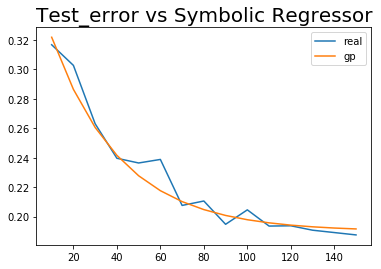

In [13]:
#Step 5: Evaluation for Symbolic Regressor

print("MSE (test_error x symbolic regressor)")

y = (np.sqrt((np.sqrt(np.sqrt(np.sqrt(np.sqrt(np.exp(-sample)))))))*0.18)+0.19
print(mean_squared_error(test_error, y.reshape(-1,1)))

plt.title('Test_error vs Symbolic Regressor',fontsize=20)
plt.plot(sample.reshape(-1,1),test_error, label = 'real')
plt.plot(sample.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 1: 
**Theoretical expectations for Empirical Error Estimation:**

Train and test error curves should coverge. (ok);
<br>Test error decreases as sample size increases until reaching irreducible error. (ok);
<br>Train error increases as samples size increases until reaching a value close to the irreducible error for test. (ok);
<br>Theoretical bounds should upper bound test error curve (ok);
<br>Observed: VC bound tighter than Rademacher bound for this experiment.

<br>**Symbolic Regression Results:**

Found a closed-form expression for test error when varying sample size which is similar to all other experiments performed varying only sample size.

$$ (c*\sqrt[32]{e^{-n}}+b) $$

<br>c and b are hyperpameters that should be set by the user. c controls the range in y-direction and b control the minimal height of the shape (usually the value of the irreducible error is a good value for b).
<br>MSE(empirical test error, symbolic regressor expression) < 10^-5 for this dataset.

## Experiment 2:  Evaluating how train and test error varies with increasing model capacity
Empirical train and test error: Missclassification Rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Test Samples = 50
<br>Train Samples = 40
<br>Varying model capacity by tree depth size = [1,2,3...,29]
<br>Run each tree 100 times and take the average for calculating the empirical erros to reduce noise. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
from random import sample

samples = 40
d = range(1,30)
n_2 = range(0,100)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []

#Test set
df_x = titanic
df_x = df_x.drop(columns = ['Survived'])
df_y = titanic['Survived']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.056)

for counter,value in enumerate(d): 
    for j in n_2:
        #step 1 - data generation
        idx = sample(range(0,len(X)), samples)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        # Create Decision Tree classifer object
        clf = DecisionTreeClassifier(max_depth= value)

        #inserting train data in model for training
        clf.fit(X_train,Y_train)

        #predicting values for train/test data
        Y_pred_test = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)

        #computing misclassification error
        acc_test = clf.score(X_test, Y_test)
        temp_test.append(1-acc_test)

        acc_train= clf.score(X_train, Y_train)
        temp_train.append(1-acc_train)

        #Rademacher constant`
        scores = np.asarray(Y_train).flatten() != Y_pred_train
        L = np.dot(s, scores)/len(Y_train)
        temp_L.append(L)

    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()
    
#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound((np.array(samples))*np.ones(len(d)), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_classification((np.array(samples))*np.ones(len(d)), np.array(Rad))
print("VC Dimension")
print(VCdim)
VCBound = VC_bound((np.array(samples))*np.ones(len(d)), np.array(train_error), VCdim, 0.1)
print("VC Bound")
print(VCBound)

Rademacher Constant
[0.175, 0.15, 0.075, 0.075, 0.1, 0.05, 0.05, 0.05, 0.025, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Rademacher Bound
[0.49431138 0.42181138 0.28981138 0.24831138 0.25156138 0.18806138
 0.18531138 0.18081138 0.15506138 0.15531138 0.13006138 0.12981138
 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138
 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138
 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138]
VC Dimension
[0.16603958 0.12198826 0.03049707 0.03049707 0.05421701 0.01355425
 0.01355425 0.01355425 0.00338856 0.00338856 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
VC Bound
[0.41070255 0.33712636 0.23811545 0.17462159 0.14271338 0.11115597
 0.10598286 0.097258   0.09360033 0.09409834 0.         0.
 0.         0.         0.    

c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


Test
[0.24259999999999995, 0.2738, 0.2912, 0.29560000000000003, 0.3147999999999999, 0.2988, 0.3072, 0.3239999999999999, 0.3142, 0.326, 0.3086, 0.31720000000000004, 0.3178000000000001, 0.316, 0.31379999999999997, 0.31200000000000006, 0.30360000000000015, 0.3014, 0.31360000000000005, 0.31240000000000007, 0.31740000000000007, 0.3142, 0.3076, 0.30200000000000005, 0.3099999999999999, 0.31060000000000004, 0.31720000000000004, 0.32080000000000003, 0.3118000000000001]
Train
[0.1895, 0.14200000000000002, 0.08500000000000002, 0.04349999999999997, 0.02175, 0.008250000000000006, 0.005500000000000004, 0.0010000000000000009, 0.0002500000000000002, 0.0005000000000000004, 0.0002500000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


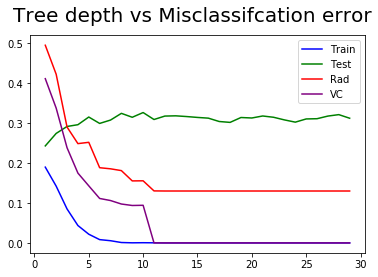

In [21]:
# Step 3: Evaluation
import matplotlib.pyplot as plt

print('Test')
print(test_error)
print("Train")
print(train_error)


plt.suptitle('Tree depth vs Misclassifcation error',fontsize=20)
plt.plot(d,train_error,color='blue', label = 'Train')
plt.plot(d,test_error,color = 'green', label = 'Test')
plt.plot(d,radBound, color = 'red', label = 'Rad')
plt.plot(d,VCBound, color = 'purple', label = 'VC')
plt.legend(loc='upper right')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0.24259999999999995, 0.2738, 0.2912, 0.29560000000000003, 0.3147999999999999, 0.2988, 0.3072, 0.3239999999999999, 0.3142, 0.326, 0.3086, 0.31720000000000004, 0.3178000000000001, 0.316, 0.31379999999999997, 0.31200000000000006, 0.30360000000000015, 0.3014, 0.31360000000000005, 0.31240000000000007, 0.31740000000000007, 0.3142, 0.3076, 0.30200000000000005, 0.3099999999999999, 0.31060000000000004, 0.31720000000000004, 0.32080000000000003, 0.3118000000000001]
100


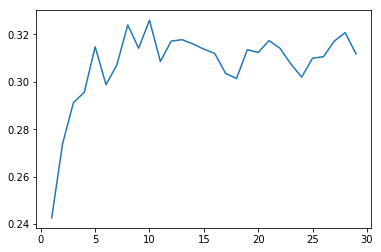

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)


   0    12.81      2.86525e+07       40          98.0007          76.7142     20.75s


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   1     6.48      3.90827e+06       21          66.1972          62.7608     18.96s
   2     8.86      6.12842e+08       21          28.1062          27.0067     16.77s
   3     9.21      1.28798e+07       38          20.8896           18.456     16.98s
   4     7.61      1.59969e+06       20          8.83573           8.5191     14.84s
   5     4.24           168470       20          8.62909            10.31     12.79s
   6     5.57           693590       20          7.77579          17.7052     13.06s
   7     9.46           243905       19          7.96054           16.104     14.08s
   8    15.52           952027       19          6.65226          11.4164     15.55s
   9    17.46          31049.9       19          6.73428          10.7055     14.76s
  10    16.75      5.29086e+07       19           7.0048            8.361     13.96s
  11    14.35      5.68494e+07       19          7.67764          18.5558     12.96s
  12    11.24      9.74683e+07       16          7.90567         

In [24]:
#Step 4: Symbolic Regression 
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt',  'abs', 'neg', 'inv', xexp]
est_gp = SymbolicRegressor(population_size=2000, generations=20, 
                           stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=5,
                           function_set = f_set)

depth = []
for i in d: 
    depth.append(i)  
print(depth)
depth = np.array([depth])
print(test_error)
print(100)
plt.plot(depth.reshape(-1,1),test_error)
plt.show()
est_gp.fit(depth.reshape(-1,1), np.dot(1000,test_error))
print(est_gp._program)

MSE (test_error x symbolic regressor)
8.852480263087881e-05


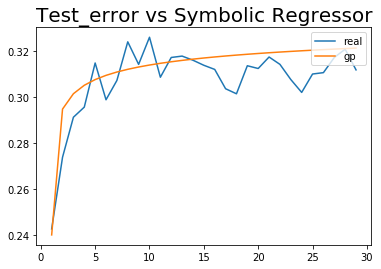

In [39]:
#Step 5: Evaluation for Symbolic Regressor

print("MSE (test_error x symbolic regressor)")

y = (np.sqrt((np.sqrt(np.log(depth))))*0.06)+0.24
print(mean_squared_error(test_error, y.reshape(-1,1)))

plt.title('Test_error vs Symbolic Regressor',fontsize=20)
plt.plot(depth.reshape(-1,1),test_error, label = 'real')
plt.plot(depth.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 2: 

**Theoretical expectations for Empirical Error Estimation:**
<br>Train error curve should decrease until irreducible error (train error goes to zero, which flags overfitting).
<br>Test error curve should present U-shape (error decreses and then increases with model capacity.The more capacity the lower the bias; the less the bias the better the ability to fit data well, which increases variance).The U-shape is not oberved in this dataset. Test error increases as deeper trees are created and then reaches a plateau.
<br>Theoretical bounds do not approximate test_error as well as in the experiments with increasing sample size. The Rademacher Bound follows the behavior of the test error curve, but not always upper bound it. The VC bound is heavily biased towards train error and fails to provide meaningful information. 

**Symbolic Regression Results:**
<br>Found a closed-form expression for test error when varying tree depth:
$$ (c*\sqrt[4]{log{-d}}+b) $$

<br>c and b are hyperpameters that should be set by the user. c controls the range in y-direction and b control the minimal height of the shape (in this case, minimal value of the test error curve). d is the depth of the tree.
<br>MSE(empirical test error, symbolic regressor expression) < 10^-5

## Experiment 3:  Evaluating how train and test error varies by changing model capacity and sample size at the same time
Empirical train and test error: Missclassification Rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Test Samples = 50
<br>Train Samples = [6,8,12...50]
<br>Varying model capacity by tree depth size = [1,2,3...,10]
<br>Run each tree 100 times and take the average for calculating the empirical erros to reduce noise. 

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn import tree
from sklearn import metrics

n = range(4,200, 10)
n_2 = range(0,100,1)
d = range(1,11)
test_error = np.zeros([len(d),len(n)])
train_error = np.zeros([len(d),len(n)])
Rad = np.zeros([len(d),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []

df_x = titanic
df_x = df_x.drop(columns = ['Survived'])
df_y = titanic['Survived']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.056)

for counter,value in enumerate(n): 
    print("Samples: ", str(value))
    for i in d:
        print("depth: ", str(i))
        for j in n_2:
            #step 1 - data generation   
            idx = sample(range(0,len(X)), value)
            X_train = X.iloc[idx]
            Y_train = Y.iloc[idx]

            #rademacher sigma
            s = rademacher_variables(len(Y_train))
            
            #step 2 - model training
            
            # Create Decision Tree classifer object
            clf = DecisionTreeClassifier(max_depth= i)

            #inserting train data in model for training
            clf.fit(X_train,Y_train)

            #predicting values for train/test data
            Y_pred_test = clf.predict(X_test)
            Y_pred_train = clf.predict(X_train)

            #computing misclassification rate for train and test
            acc_test = clf.score(X_test, Y_test)
            temp.append(1-acc_test)

            acc_train= clf.score(X_train, Y_train)
            temp_train.append(1-acc_train)

            #Rademacher constant`
            scores = Y_train != Y_pred_train
            L = np.dot(s, scores)/len(Y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = np.zeros([len(d),len(n)])
c =3*(np.sqrt(np.log(2/0.1))/(2*(np.array(n))))
for i in range(0,len(d)):
    radBound[i] = np.add(train_error[i], Rad[i])
    radBound[i] = np.add(radBound[i],c)
print("Rademacher Bound")
print(radBound)

Samples:  4
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  14
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  24
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  34
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  44
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  54
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  64
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  74
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10
Samples:  84
depth:  1
depth:  2
depth:  3
depth:  4
depth:  5
depth:  6
depth:  7
depth:

Min Missclassification Rate:  0.22899999999999981
Position of min error:  (array([3], dtype=int64), array([18], dtype=int64))
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[4, 14, 24, 34, 44, 54, 64, 74, 84, 94, 104, 114, 124, 134, 144, 154, 164, 174, 184, 194]

Min Missclassification Rate for each tree with depth d
[0.2508 0.2422 0.2324 0.229  0.2366 0.2428 0.2404 0.2528 0.2528 0.2554]


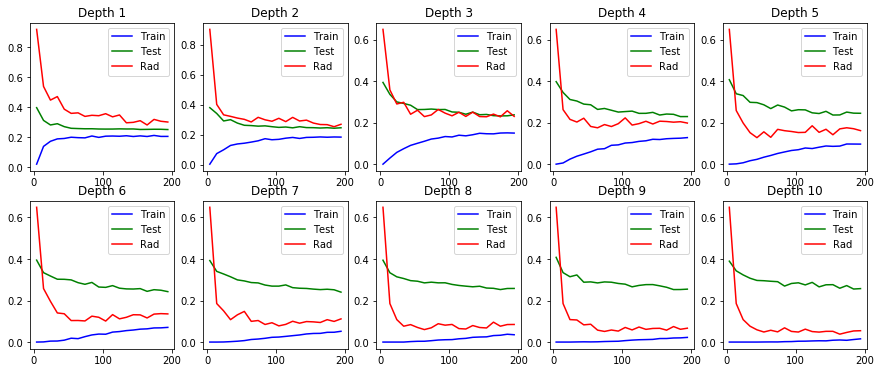

In [41]:
#Step 3: evaluation

import matplotlib.pyplot as plt

print("Min Missclassification Rate: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min error: ', pos)
print(list(d))
print(list(n))

print('\nMin Missclassification Rate for each tree with depth d')
print(np.amin(test_error, axis = 1))

#plotting
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.flatten()
for i in d:
    axs[i-1].plot(n, train_error[i-1,:], color = 'blue', label = 'Train')
    axs[i-1].plot(n, test_error[i-1,:], color = 'green', label = 'Test')
    axs[i-1].plot(n, radBound[i-1], color = 'red', label = 'Rad')
    axs[i-1].legend(loc='upper right')
    axs[i-1].set_title("Depth %d" %i)
plt.show()


In [42]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=5000, metric = 'rmse',
                           generations=30, stopping_criteria=0.1,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.2,
                           max_samples=0.8, verbose=1,
                           parsimony_coefficient=0.5, random_state=0,
                           function_set = f_set)
depth = []
samples = []
for i in d: 
    depth.append(i)  
for i in n: 
    samples.append(i)  

a = np.transpose([ np.repeat(samples, len(depth)), np.tile(depth, len(samples))])
error = np.array(list(test_error.flatten()))
est_gp.fit(a,1000*error)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    11.93      3.12579e+09       12          42.3965           44.906      1.26m
   1    10.23       1.8223e+09       12          41.2982          42.1327      1.38m
   2    11.17      3.57301e+06       12          36.3339          41.8303      1.19m
   3    11.69      9.57735e+06       12          34.3827          47.9762      1.24m
   4    11.10      7.70702e+06       12           34.806          46.7392      1.24m
   5     9.75      1.02011e+07       19          31.5234          37.4685      1.11m
   6     9.90      1.06093e+07       19          30.9988          38.4665     59.58s
   7    10.46      9.64693e+06       17          29.6563          41.9256     58.66s
   8     9.24       1.1554e+07       19          30.7308          40.0159     52.40s
   9     7.62       1.1188e+07       19          31.9229          36.0902     47.97s
  10     7.11      1.21129e+07        7          31.5491          54.7382     43.59s
  11     6.99      1.31435e+07        7          30.7738         

MSE (test_error x symbolic regressor)
0.07831360074090847


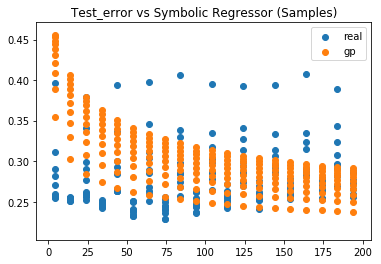

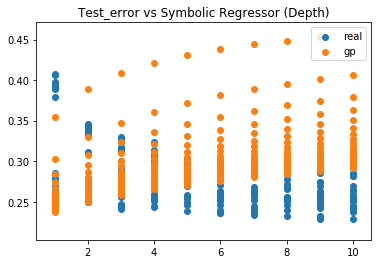

In [47]:
#Step 5: Evaluation for Symbolic Regressor

y = np.exp(np.sqrt(np.sqrt(a[:,1]/(a[:,0] + a[:,1]))))/5.5

print("MSE (test_error x symbolic regressor)")
print(mean_squared_error(error, y/1000))

plt.title("Test_error vs Symbolic Regressor (Samples)")
plt.scatter(a[:,0], error, label = 'real')
plt.scatter(a[:,0], y, label = "gp")
plt.legend(loc = 'upper right')
plt.show()

plt.title("Test_error vs Symbolic Regressor (Depth)")
plt.scatter(a[:,1], error, label = 'real')
plt.scatter(a[:,1], y, label = "gp")
plt.legend(loc = 'upper right')
plt.show()

### Conclusions experiment 3: 
**Empirical Error Estimation Results:**
<br>The missclassification rate decreases until reaching depth 4 (its minimum =22.9%) with 184 samples, then increases as deeper trees are trained.
<br>Rademacher bounds seems to be more robust againts the effect of train error going to zero, but it is loose when compared to the test error (mainly for small sample size). It upper bounds test error until depth = 3 then lower bounds as train error ~ 0.

**Symbolic Regression Results:**
<br>Found a closed-form expression for test error when varying tree depth:
$$ (c*{e^{\sqrt[4]d/n + n }}) $$

<br>c is a hyperpameter that should be set by the user. c controls the range in y-direction. N is the number of samples and d is the depth of the tree.
<br>MSE(empirical test error, symbolic regressor expression) < 0.08